---
title: "MircoGrad"
author: "Suchith Prabhu"
date: "2023-03-14"
image: "images/autograd.png"
description: Many of us have likely utilized Pytorch and its autograd functionality. Have you ever considered the inner workings of the autograd feature? Its algorithmic brilliance is truly awe-inspiring.
jupyter: python3
sidebar: false
draft: true

---

In [377]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

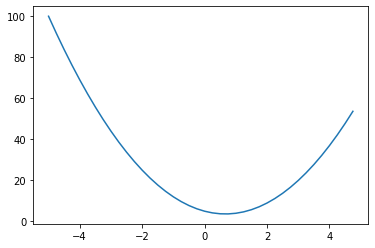

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

In [13]:
h = 0.000000001
x = -3.0
print(f"Gradient at {x} is {(f(x+h) - f(x))/h}")

Gradient at -3.0 is -22.000001820288162


In [328]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other, label='const')
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad  
        out._backward = _backward
        
        return out 
    
    
    def __radd__(self, other):
        return self + other
    
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other, label='const')
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    
    def __rmul__(self, other):
        return self * other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self - other
    
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        
        return out
            
    
    def __truediv__(self, other):
        return self * other**-1
    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    
    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
        
    
    def backward(self):
        
        order = list()
        visited = set()
        def topological_sort(node):
            visited.add(node)
            for child in node._prev:
                if child not in visited:
                    topological_sort(child)
            order.append(node)
            
        topological_sort(self)
        
        self.grad = 1.0
        for node in reversed(order):
            node._backward()
    

## Engine

In [97]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = f * d; L.label = 'L'

In [70]:
from graphviz import Digraph

def get_graph_elements(start):
    nodes, edges = set(), set()
    def build(node):
        if node not in nodes:
            nodes.add(node)

        for child in node._prev:
            edges.add((child, node))
            build(child)   
    build(start)
    return nodes, edges

def draw_dot(start):
    nodes, edges = get_graph_elements(start)
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    for node in nodes:
        dot.node(str(id(node)), label="{ %s | %f | %f }"%(node.label, node.data, node.grad), shape='record')
        if node._op:
            dot.node(str(id(node))+node._op, label=node._op)
            dot.edge(str(id(node))+node._op, str(id(node)))
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot

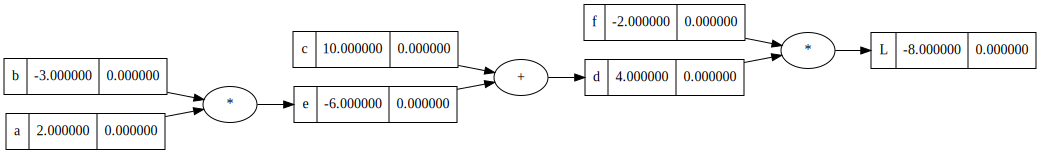

In [98]:
draw_dot(L)

In [89]:
def manual():
    
    h = 0.00001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = f * d; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = f * d; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)
    
manual()

-4.000000000026205


In [99]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0
c.grad = -2.0
b.grad = -4.0
a.grad = 6.0

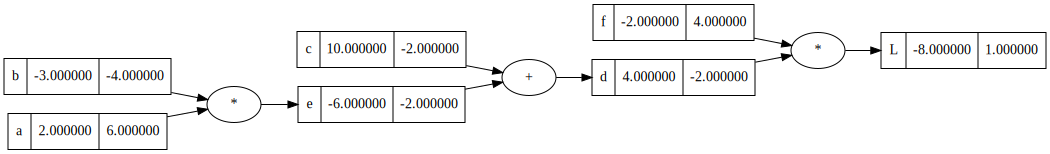

In [100]:
draw_dot(L)

In [101]:
f.data += 0.01 * f.grad 
c.data += 0.01 * c.grad 
b.data += 0.01 * b.grad 
a.data += 0.01 * a.grad

In [102]:
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
L = f * d; L.label = 'L'

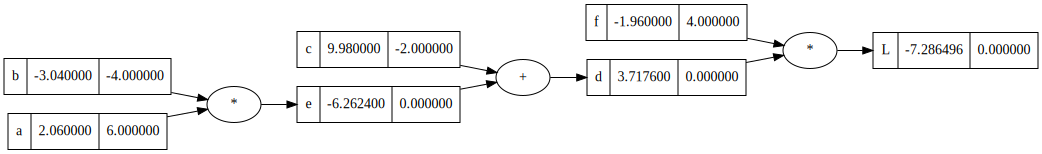

In [103]:
draw_dot(L)

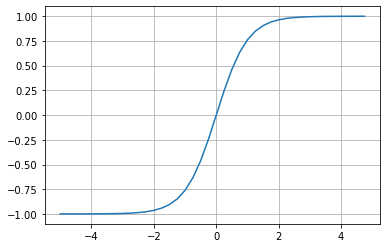

In [106]:
xs = np.arange(-5, 5, 0.25) 
ys = np.tanh(xs)
plt.plot(xs, ys); plt.grid()

In [316]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8814, label='b')

w1x1 = w1*x1; w1x1.label = 'w1*x1'
w2x2 = w2*x2; w2x2.label = 'w2*x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1*x1 + w2*x2'

n = w1x1w2x2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

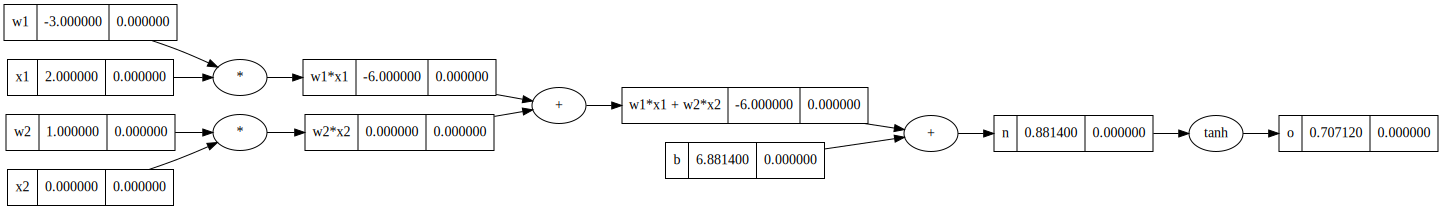

In [317]:
draw_dot(o)

In [138]:
o.grad = 1.0
n.grad = 0.5
w1x1w2x2.grad = 0.5
b.grad = 0.5
w1x1.grad = 0.5
w2x2.grad = 0.5
w1.grad = 1.0
w2.grad = 0.0
x1.grad = -1.5
x2.grad = 0.5

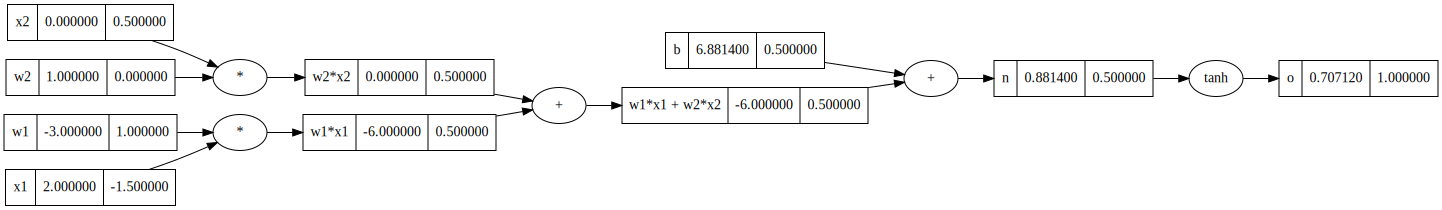

In [139]:
draw_dot(o)

In [151]:
o.grad = 1.0
o._backward()
n._backward()
w1x1w2x2._backward()
w1x1._backward()
w2x2._backward()

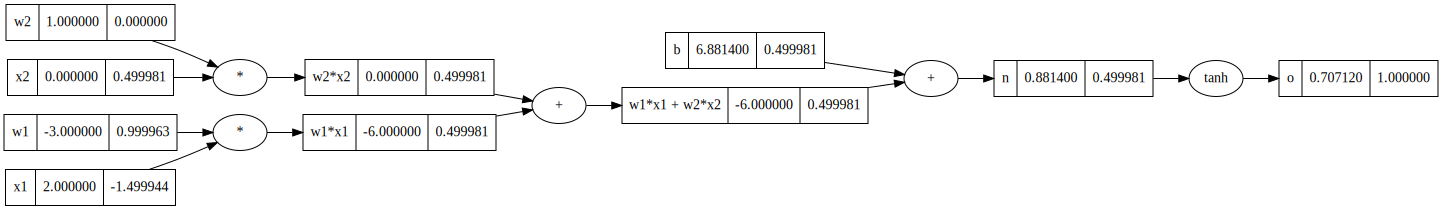

In [152]:
draw_dot(o)

In [318]:
o.grad = 1.0

order = list()
visited = set()
def topological_sort(node):
    visited.add(node)
    for child in node._prev:
        if child not in visited:
            topological_sort(child)
    order.append(node)
topological_sort(o)

for node in reversed(order):
    node._backward()

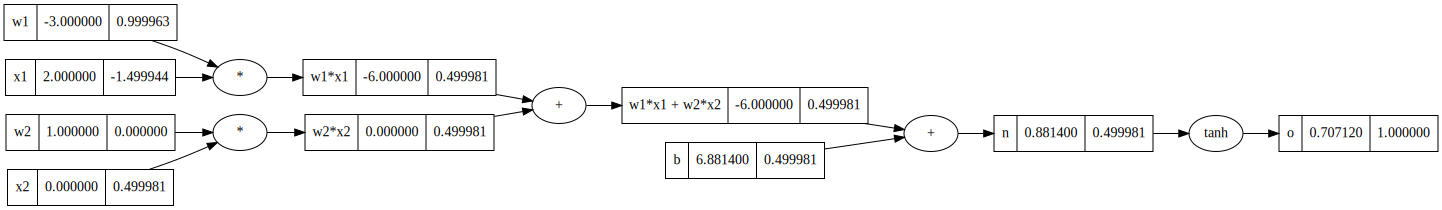

In [320]:
draw_dot(o)

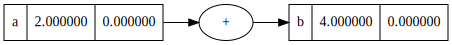

In [178]:
a = Value(2, label='a')
b = a + a; b.label = 'b'

draw_dot(b)

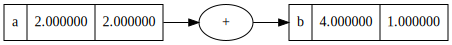

In [179]:
b.backward()
draw_dot(b)

In [329]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8814, label='b')

w1x1 = w1*x1; w1x1.label = 'w1*x1'
w2x2 = w2*x2; w2x2.label = 'w2*x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1*x1 + w2*x2'

p = w1x1w2x2 + b; p.label = 'p'
q = 2 * p; q.label = 'q'
expq = q.exp(); expq.label = 'expq'

n = expq - 1; n.label = 'n'
d = expq + 1; d.label = 'd'
o = n/d; o.label = 'o'

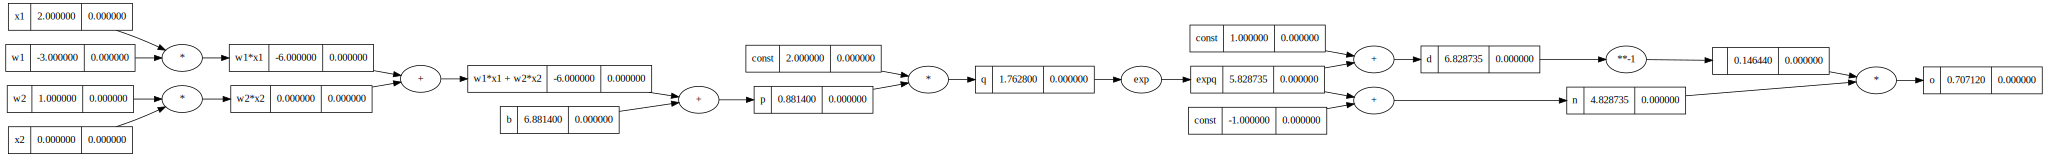

In [330]:
draw_dot(o)

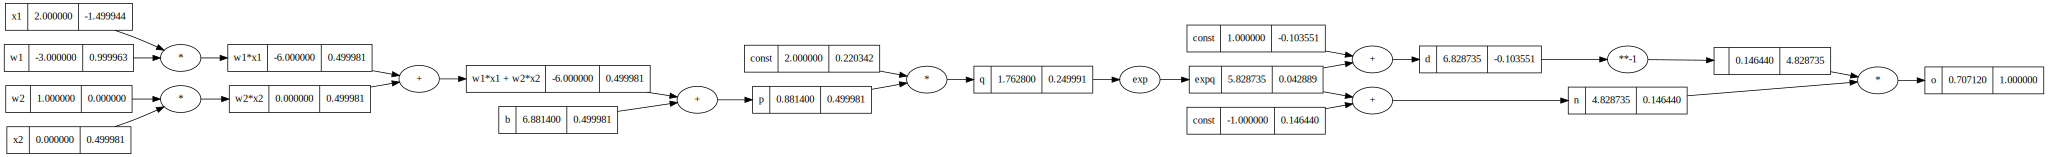

In [331]:
o.backward()
draw_dot(o)

In [347]:
import torch

In [369]:
x1 = torch.tensor(2.0, requires_grad=True)
w1 = torch.tensor(-3.0, requires_grad=True)
x2 = torch.tensor(0.0, requires_grad=True)
w2 = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(6.881400, requires_grad=True)

n = w1*x1 + w2*x2 + b
n.retain_grad()
o = torch.tanh(n)
o.retain_grad()

In [370]:
o.backward()

In [376]:
print("Gradient of x1 : %f"%x1.grad.item())
print("Gradient of w1 : %f"%w1.grad.item())
print("Gradient of x2 : %f"%x2.grad.item())
print("Gradient of w2 : %f"%w2.grad.item())

Gradient of x1 : -1.499944
Gradient of w1 : 0.999962
Gradient of x2 : 0.499981
Gradient of w2 : 0.000000


## Module

In [449]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act = sum([i*j for i,j in zip(self.w, x)], self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        out = [neuron(x) for neuron in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
    
class MLP:
    
    def __init__(self, nin, nout):
        sz = [nin] + nout
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nout))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [450]:
nn = MLP(3, [4, 4, 1])

In [451]:
x = [1.0, 3.0, 5.5]
out = nn(x); out

Value(data=-0.44895619664539943)

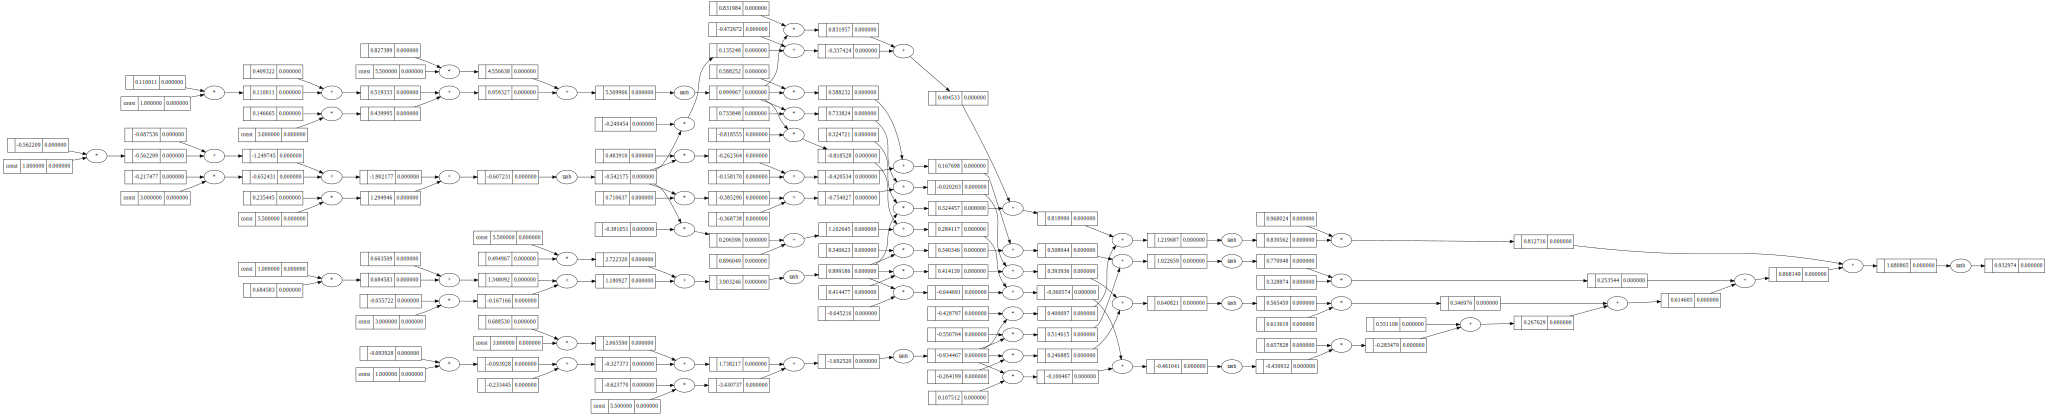

In [439]:
draw_dot(out)

In [452]:
xs = [[1.0, 3.0, -1.0, 2.0],
      [-1.0, 0.5, 1.0, 6.0],
      [3.0, 1.5, -1.0, 2.5],
      [-1.0, 7.0, 3.0, 3.0]]
ys = [1.0, -1.0, 1.0, -1.0]



In [458]:
ypred = [nn(x) for x in xs]
loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=4.20749604459977)

In [459]:
loss.backward()

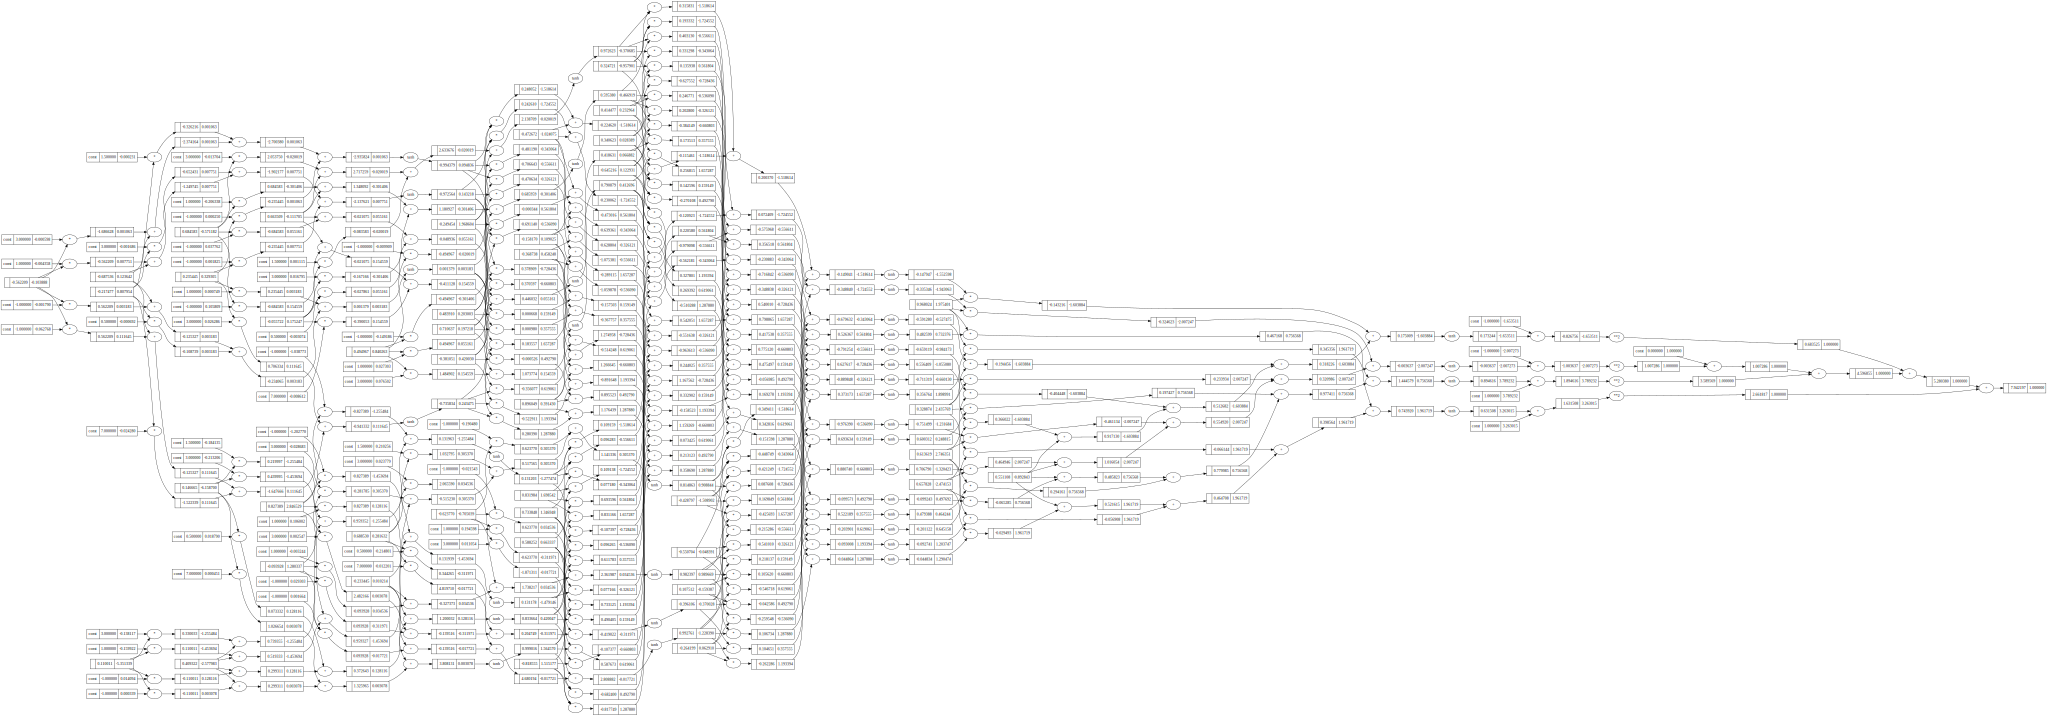

In [447]:
draw_dot(loss)

In [462]:
for p in nn.parameters():
    p.data += -0.01 * p.grad

In [463]:
ypred = [nn(x) for x in xs]
loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=2.9193346577538652)

In [480]:
for k in range(20):
    ypred = [nn(x) for x in xs]
    loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
    
    for p in nn.parameters():
        p.grad = 0.0
    loss.backward()
    
    for p in nn.parameters():
        p.data += -0.1 * p.grad
        
    print(k, loss.data)

0 0.0014922142820839803
1 0.0014833382897962229
2 0.0014745626442129246
3 0.0014658856860760914
4 0.0014573057921043581
5 0.0014488213740302153
6 0.0014404308776678261
7 0.0014321327820102311
8 0.0014239255983551145
9 0.00141580786945779
10 0.001407778168710639
11 0.001399835099347932
12 0.0013919772936751614
13 0.0013842034123220607
14 0.0013765121435183587
15 0.0013689022023915809
16 0.0013613723302860572
17 0.001353921294102395
18 0.0013465478856567504
19 0.0013392509210591414


In [482]:
ypred

[Value(data=0.980749071290304),
 Value(data=-0.9942829799936868),
 Value(data=0.9824558766125259),
 Value(data=-0.9749366386594727)]